# CA1

## Introduction

Network systems are a combination of hardware and software used for various network transactions. Firewall systems control and monitor incoming and outgoing network traffic to detect unauthorized access. Machine learning algorithms have been applied in various real-world problems and may outperform classical network systems in preventing unauthorized internet access.

Firewall log activities require analysis to determine exactly what is allowed, dropped, and denied. It is not easy due to working with large raw data collected from the Internet Access Management in different periods of time. Firewall log files become high volume, and the systems used are olume and the systems used are
inca.

The main goal of this assignment is to use Machine Learning model to analyze network traffic 
dataseses. The utilized models includDecision Tree, Random Forest And K-Nearest Neighbor (K-NN)NN. T e
modeaimaim to predict the recommended action to be takconcerning to each session
as traffic flows through the netwoAfter applying the modelmore, we assessed the performance of t ese
classifiers in terms of accuracy, precision, r, andcalscore.d ROCpable of handling extensive data

### •	Perform an initial analysis of the data (EDA) using python in your Jupyter notebook. Discuss your findings and what relevance they might have on your planned classification algorithms. 

Exploratory data analysis (EDA) is an important and recommended first step prior to the training of a
machine learning model. In the rest of this section, we will use some simple yet useful techniques from the
graphical EDA toolbox that may help us to visually detect the presence of outliers, the distribution of the
data, and the relationships between features.(Raschka and Mirjalili, 2019)


In [ ]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as pltimg
import pydotplus
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing 
from sklearn import tree

In [ ]:
#reading file
data = pd.read_csv("log2.csv")

data.head()

Let's start using .describe() and .info() to pull information about the dataset. 

- .describe() - Allow the understanding of each feature (Column). It is possible to see on the numerical features the huge gap between the Q3(75%) and the max values. Also, the categorical values "NATSource Port" and "NAT Destination Port" have a huge presence of 0 values.
- .info() - Effect way to check for missing or null values.

In [ ]:
data.describe()

In [ ]:
data.info()

In [ ]:
# Calculate the top unique values for each column
top_unique_values = {column: data[column].value_counts().head(3) for column in data.columns}

top_unique_values

### Understanding the target value (Action) 

we were provided with a network log dataset that contains 65k observations. 
- 57.43% "Allow"
- 22.86% "Deny"
- 19.61% "Drop"
- 0.08% "Reset-both"

In [ ]:
# target distribution
print('Absolute Frequencies:')
print(data.Action.value_counts())
print()

print('Percentages:')
print(data.Action.value_counts(normalize=True))

data.Action.value_counts().plot(kind='bar')
plt.title('Target (Action)')
plt.grid()
plt.show()

### Analyzing Numerical features.

 The values are written in scientific notation, also known as exponential notation. I used "np.log10(1+x)" to compress the large scale of the numerical values to a more manageable range. 

- Upon analyzing the boxplot, it is evident that most of the features have a right-skewed distribution. This kind of skewness suggests that many observations typically involve smaller amounts of data or packets. However, it also indicates that some observations contain outliers that involve larger values (data or packets). In this context, it might be explained as large files transfers or streaming sessions on the network traffic.
- After analyzing the histograms, it confirms that the majority of the observations contain small values (data or packet), then going towards the lower end of the graph with bigger values.

In [ ]:
features_num = ['Bytes', 'Bytes Sent', 'Bytes Received',
                'Packets', 'Elapsed Time (sec)', 
                'pkts_sent', 'pkts_received']

In [ ]:
# define log trafo for numerical features
def graph(x):
    return np.log10(1+x)

In [ ]:
# plot distribution of numerical features
for f in features_num:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11,7), sharex=True)
    ax1.hist(graph(data[f]), bins=20)
    ax1.grid()
    ax1.set_title('Feature: ' + f + ' -[log_10(1+x)]')
    ax2.boxplot(graph(data[f]), vert=False)
    ax2.grid()   
    ax2.set_title('Feature: ' + f + ' -[log_10(1+x)]')
    plt.show()

### Analyzing Categorical Features

Even though these features are composed of numbers only, each number represents a specific port on the network (e.g. 443 = HTTPS). In this case would make no sense to use a boxplot as the range of the numbers won't mean anything. Instead, I have counted the most 10 values that appear on each feature.

#### Most used ports in the dataset:
- Source Port: Port 58638 (TCP/UCP).
- Destination Port: Port 53 (DNS), 445 (SMB) and 443(HTTPS).
- NAT Source Port: Port 0 has 28432 observations. * Might be represented by sessions that did NOT require a NAT Source Port, or missed data or packet.
- NAT Destination Port: There are an equal number of 0s, but there are significant observations for ports 53 and 443, 15094 and 11678 respectively.

In [ ]:
features_cat = ['Source Port', 'Destination Port', 'NAT Source Port', 'NAT Destination Port']

In [ ]:
# show only top 10 levels for each feature
for f in features_cat:
    print('Feature:', f)
    print(data[f].value_counts()[0:10])
    print()
    data[f].value_counts()[0:10].plot(kind='bar')
    plt.title(f)
    plt.grid()
    plt.show()

In [ ]:
# visualize crosstable target vs feature (using top 10 levels only)
for f in features_cat:
    top10_levels = data[f].value_counts()[0:10].index.to_list()
    data_temp = data[data[f].isin(top10_levels)]
    ctab = pd.crosstab(data_temp.Action, data_temp[f])
    print('Feature:' + f + ' - Top 10 levels only')
    plt.figure(figsize=(12,5))
    sns.heatmap(ctab, annot=True, fmt='d', 
                cmap='Blues',
                linecolor='black',
                linewidths=0.1)
    plt.show()

In the dataset, we could be able to notice that there are some "Ports" such 53, 80 and 443 that are highly correlated to "Allow", which make sense as they are related to web services (80 and 443) and DNS (53).
The massive number of observations that contain the number 0 in the NAT Source Port and Destination Port, are mostly represented in "Deny" or "Drop".

### Correlation Matrix
The correlation matrix is a square matrix that contains the Pearson product-moment correlation
coefficient (often abbreviated as Pearson's r), which measures the linear dependence between pairs of
features. The correlation coefficients are in the range –1 to 1. Two features have a perfect positive
correlation if r = 1, no correlation if r = 0, and a perfect negative correlation if r = –1. As mentioned
previously, Pearson's correlation coefficient can simply be calculated as the covariance between two
features, x and y (numerator), divided by the product of their standard deviations (denominator).(Raschka and Mirjalili, 2019)

In the following code example, we use .corr function on the eleven feature columns that we
previously visualize, and we will use the heatmap graph to plot the correlation matrix:

In [ ]:
# Selecting and storing all columns except the last one in a new variable
data_corr = data.iloc[:, :-1]

In [ ]:
# Calculate the correlation matrix for the entire dataset
correlation_matrix = data_corr.corr()


# Plot the heatmap for the correlation matrix
plt.figure(figsize=(14, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', annot_kws={"size": 10})
plt.title('Correlation Matrix of Numerical Variables')
plt.xticks()
plt.yticks()
plt.tight_layout() 
plt.show()

# DATA PREPARATION

Data preparation follows data understanding through EDA when data is manipulated and converted into forms that yield better results.(Provost and Fawcett, 2013)
Preparing the data includes removing or inferring missing values, and converting data to different types. This is a crucial process, and maybe the one that most confuses Data Scientists, especially the ones who do not have any experience. Usually, when taking an e-course or YouTube tutorial, the datasets come with no missing values, no bias, no skewed data, and ready-to-apply models. In the real world, the majority time of your job is preparing the data to apply the models, which are pretty simple and do not take time (as long as the data is well-cleaned). In addition, numerical values must often be scaled or normalized, it depends on the data, to be comparable across the features. Different features scales can lead models that rely on the distance between data points, such as k-nearest neighbors (KNN), to perform very poorly.




In [ ]:
# Check for missing values
missing_values = data.isnull().sum()
missing_values

In [ ]:
# check for duplicates values
duplicates = data[data.duplicated(keep=False)]  # Finds all duplicates, not just the first occurrence
duplicates

In [ ]:
# Calculate the top unique values for each column
top_unique_values = {column: duplicates[column].value_counts().head(3) for column in duplicates.columns}

top_unique_values

In [ ]:
# Drop the duplicate rows from the original dataset
#data.drop_duplicates(inplace=True)
#data.info()

In [ ]:
label_encoder = preprocessing.LabelEncoder() 
  
data['Action']= label_encoder.fit_transform(data['Action']) 

We are following to next step which is the modeling stage, where data mining techniques are applied to the data. It's the scientific and technological aspects that prepare the machine learning model for application. In this study, the problem is not only applying the selected models but also evaluating each of them. In addition, the model's parameters and attributes, will be tested to define which will be suitable for each model to better classify the predict incoming networking traffic.

Then, we have the evaluation stage, which is to assess the data mining results and gain confidence that they are valid and reliable before moving on. It is possible to deploy results immediately after data mining but this is not the best way to proceed as your model might be not reliable
In the real world, every business has a goal when applying a machine learning model, and the evaluation stage also serves to help ensure that the model satisfies it.

# Machine Learning Models

## Classification model

Classification is the process of finding a model (or function) that describes and distinguishes data classes or concepts. The model is derived based on the analysis of a set of training data. The model is used to predict the class label of objects for which the class label is unknown (Supervised Learning). “How is the derived model presented?” The derived model may be represented in various forms, such as classification rules. (Han and Kamber, 2006) The most known rule may be the IF-THEN rule, which has numerous applications, including target marketing, fraud detection, medical diagnosis, and performance predictions.

Machine Learning Models are divided into different groups. They are: Supervised Learning, Unsupervised Learning, Semi-Supervised Learning and Active Learning and Reiforced Learning. Most of classification models are Supervised Learning, with some exceptions like Clustering, that can be used for categorization tasks without labeled data. 

## Evaluation Metrics

This section presents the evaluation metrics used for the performance assessment of the classification models. This paper evaluates the classification performance of the used models using classification accuracy, precision, recall, F-measure, and ROC.


Before we get into the details of different scoring metrics, let's take a look at a confusion matrix, a matrix that lays out the performance of a learning algorithm. A confusion matrix is simply a square matrix that reports the counts of the true positive (TP), true negative (TN), false positive (FP), and false negative (FN) predictions of a classifier, as shown in the following figure:

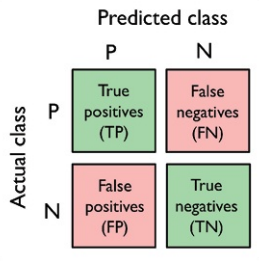

Figure 1: Confusion Matrix (Raschka and Mirjalili, 2019)


The accuracy demonstrates the proportion of the total number of correct predictions, which is the value of successfully classified instances. The classification accuracy is calculated by dividing the total number of predictions that were correct by the total number of predictions.

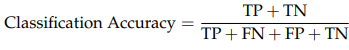

Figure 2: Accuracy (Aljabri et al., 2022)


Precision is calculated quantifying the number of positives, “Anomalous” instances out of all the instances predicted as “Anomalous”. 


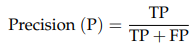

Figure 3: Precision (Aljabri et al., 2022)


As for recall, it also predicts the positive class predictions, however, it is calculated over the number of “Anomalous” instances in the dataset itself regardless of whether or not they were correctly predicted. 


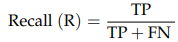

Figure 4: Recall (Aljabri et al., 2022)


Finally, the F-measure provides a single count that combines the values of the precision and recall in one number.


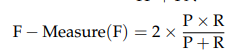

Figure 5: F-measure (Aljabri et al., 2022)

## Decision Tree

In [ ]:
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values


In [ ]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [ ]:
# Define the base model
dtc = DecisionTreeClassifier(random_state=42)

# Define the grid of parameters to search
param_DT = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4]
}

In [ ]:
grid_search = GridSearchCV(estimator=dtc, param_grid=param_DT, cv=5, verbose=2, n_jobs=-1)

In [ ]:
grid_search.fit(X_train, y_train)

In [ ]:
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

In [ ]:
best_modelDT = grid_search.best_estimator_
test_scoreDT = best_modelDT.score(X_test, y_test)
print("Test Score:", test_scoreDT)

In [ ]:
# Training the Decision Tree Classification model on the Training set
classifierDt = DecisionTreeClassifier(criterion = 'entropy', max_depth = None, min_samples_leaf = 4, min_samples_split = 2)
classifierDt.fit(X_train, y_train)

In [ ]:
# Predicting the Test set results
y_pred = classifierDt.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

In [ ]:
mat_confDT = confusion_matrix(y_test, y_pred)
print(mat_confDT)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
plt.figure( figsize = (8,5))
sns.heatmap(mat_confDT, annot=True, fmt=".1f")


## Random Forest


In [ ]:
# Define the base model
rfc = RandomForestClassifier(random_state=42)

# Specify parameters and distributions to sample from
param_RF = {
    'n_estimators': [100, 200, 300],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'log2']
}

In [ ]:
# Setup the randomized search with 10 iterations and a cross-validation of 5
#randomized_search = RandomizedSearchCV(rfc, param_distributions=param_RF, n_iter=10, cv=5, verbose=1, scoring ='accuracy', n_jobs=-1)


In [ ]:
randomized_search.fit(X_train, y_train)

In [ ]:
print("Best Parameters:", randomized_search.best_params_)
print("Best Score:", randomized_search.best_score_)

In [ ]:
best_modelRF = randomized_search.best_estimator_
test_scoreRF = randomized_search.score(X_test, y_test)
#test_scoreRF = best_modelRF.score(X_test, y_test)
print("Test Score:", test_scoreRF)

In [ ]:
# Training the Random Forest Classification model on the Training set
classifierRf = RandomForestClassifier(n_estimators = 100, min_samples_split = 4, min_samples_leaf = 2, max_features = 'auto', max_depth = 10, criterion = 'entropy')
classifierRf.fit(X_train, y_train)

In [ ]:
# Predicting the Test set results
y_pred = classifierRf.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

In [ ]:
mat_confRF = confusion_matrix(y_test, y_pred)
print(mat_confRF)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
plt.figure( figsize = (8,5))
sns.heatmap(mat_confRF, annot=True, fmt=".1f")

## K-Nearest Neighbour

In [ ]:
# Define the base model
knn = KNeighborsClassifier()

# Specify parameters and distributions to sample from
param_dist_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],  # Number of neighbors to use
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algorithm used to compute the nearest neighbors
    'leaf_size': [20, 30, 40, 50],  # Leaf size passed to BallTree or KDTree
    'p': [1, 2]  # Power parameter for the Minkowski metric
}

In [ ]:
# Initialize the RandomizedSearchCV object
random_search = RandomizedSearchCV(knn, param_distributions=param_dist_knn, n_iter=10, cv=5, verbose=2, n_jobs=-1, random_state=42)

In [ ]:
# Fit the model
random_search.fit(X_train, y_train)

In [ ]:
# Print the best parameters and the corresponding score
print("Best Parameters found: ", random_search.best_params_)
print("Best score found: ", random_search.best_score_)

In [ ]:
best_modelKNN = random_search.best_estimator_
test_scoreKNN = random_search.score(X_test, y_test)
#test_scoreKNN = best_modelKNN.score(X_test, y_test)
print("Test Score:", test_scoreKNN)

In [ ]:
#Training the model

classifierKnn = KNeighborsClassifier (weights = 'distance', p = 1, n_neighbors = 5, leaf_size = 30, algorithm = 'auto')
classifierKnn.fit(X_train, y_train)

In [ ]:
# Predicting the Test set results
y_pred = classifierKnn.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

In [ ]:
mat_confKnn = confusion_matrix(y_test, y_pred)
print(mat_confKnn)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
plt.figure( figsize = (8,5))
sns.heatmap(mat_confKnn, annot=True, fmt=".1f")

# References

Raschka, S. and Mirjalili, V. (2019). Python machine learning : machine learning and deep learning with python, scikit-learn, and tensorflow 2. Birmingham: Packt Publishing, Limited.

‌Provost, F. and Fawcett, T. (2013). Data science for business : what you need to know aboout data mining an data-anal. Beijing Etc.: O’reilly.
Kirk, M. (2017). Thoughtful Machine Learning with Python. ‘O’Reilly Media, Inc.’
Andriy Burkov (2019). THE HUNDRED-PAGE MACHINE LEARNING BOOK. Andriy Burkov.
Müller, A.C. and Guido, S. (2017). Introduction to machine learning with Python : a guide for data scientists. Beijing: O’reilly.
scikit-learn (2019). sklearn.model_selection.RandomizedSearchCV — scikit-learn 0.21.3 documentation. [online] Scikit-learn.org. Available at: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html.
scikit-learn (2019). sklearn.model_selection.GridSearchCV — scikit-learn 0.22 documentation. [online] Scikit-learn.org. Available at: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html.
scikit-learn (2019). sklearn.neighbors.KNeighborsClassifier — scikit-learn 0.22.1 documentation. [online] Scikit-learn.org. Available at: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html.
Scikit-learn (2018). sklearn.ensemble.RandomForestClassifier — scikit-learn 0.20.3 documentation. [online] Scikit-learn.org. Available at: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html.
scikit learn (2019). sklearn.tree.DecisionTreeClassifier — scikit-learn 0.22.1 documentation. [online] Scikit-learn.org. Available at: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifihtmlHan, J. and Kamber, M. (2006). Data mining : concepts and techniques. Amsterdam: Elsevier.
Aljabri, M., Alahmadi, A.A., Mohammad, R.M.A., Aboulnour, M., Alomari, D.M. and Almotiri, S.H. (2022). Classification of Firewall Log Data Using Multiclass Machine Learning Models. Electronics, 11(12), p.1851. doi:https://doi.org/10.3390/electronics11121851.

‌
‌.

‌
‌
‌
‌
‌
‌
‌
‌
‌